# PS Parallel Programming / Sheet 03
# Fabio Valentini / MN 01078782

In [17]:
# initial setup

import subprocess

from IPython.display import HTML, set_matplotlib_formats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import parse

%matplotlib inline
set_matplotlib_formats('svg')

SAMPLE_SIZE = 10
THREADS = 16

## Exercise 1: Monte-Carlo-Pi With OpenMP

The Monte-Carlo-Pi implementation based on POXIS Threads from Assignment 02 was adapted to use OpenMP instead, with different methods for synchronization:

- `critical` sections → `./ex1/mcpi_critical.c`
- `atomic` statements → `./ex1/atomic.c`
- `reduction` clauses → `./ex1/mcpi_reduction.c`

### Local performance measurements

In [2]:
parser = parse.Parser("Iterations: {iterations}; pi: {pi}; time: {time:.5f}")

threads = [*range(1, THREADS+1)]

critical = []
atomic = []
reduction = []

# run parallel monte-carlo-pi implementation with different number of threads
for p in threads:
    ret = subprocess.run(
        ["./ex1/mcpi_critical-O2"],
        env={"OMP_NUM_THREADS": str(p)},
        stdout=subprocess.PIPE,
    )
    critical.append(parser.parse(ret.stdout.decode())["time"])

    ret = subprocess.run(
        ["./ex1/mcpi_atomic-O2"],
        env={"OMP_NUM_THREADS": str(p)},
        stdout=subprocess.PIPE,
    )
    atomic.append(parser.parse(ret.stdout.decode())["time"])

    ret = subprocess.run(
        ["./ex1/mcpi_reduction-O2"],
        env={"OMP_NUM_THREADS": str(p)},
        stdout=subprocess.PIPE,
    )
    reduction.append(parser.parse(ret.stdout.decode())["time"])

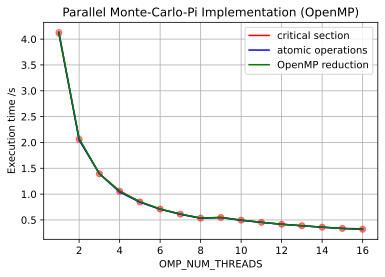

In [3]:
plt.plot(threads, critical, "ro", alpha=0.2)
plt.plot(threads, atomic, "ro", alpha=0.2)
plt.plot(threads, reduction, "ro", alpha=0.2)

plt.plot(threads, critical, "r-", label="critical section")
plt.plot(threads, atomic, "b-", label="atomic operations")
plt.plot(threads, reduction, "g-", label="OpenMP reduction")

plt.title("Parallel Monte-Carlo-Pi Implementation (OpenMP)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")

plt.legend()
plt.grid()
plt.show()

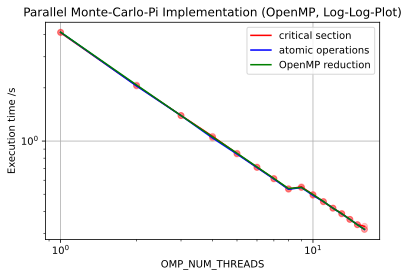

In [4]:
plt.plot(threads, critical, "ro", alpha=0.2)
plt.plot(threads, atomic, "ro", alpha=0.2)
plt.plot(threads, reduction, "ro", alpha=0.2)

plt.plot(threads, critical, "r-", label="critical section")
plt.plot(threads, atomic, "b-", label="atomic operations")
plt.plot(threads, reduction, "g-", label="OpenMP reduction")

plt.title("Parallel Monte-Carlo-Pi Implementation (OpenMP, Log-Log-Plot)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

Similar to the benchmarks for POSIX Threads, performance scales almost linearly with the number of available threads, again with a small break between 8 and 9 threads, with no noticable difference between using a critical section, atomics, or OpenMP reduction operation for gathering the final result.

In [5]:
data = np.array([threads, critical, atomic, reduction]).T

df = pd.DataFrame(
    data,
    index=threads,
    columns=[
        "OMP_NUM_THREADS",
        "critical /s",
        "atomic /s",
        "reduction / s",
    ]
)

HTML(df.to_html(index=False))

OMP_NUM_THREADS,critical /s,atomic /s,reduction / s
1.0,4.10273,4.12916,4.13386
2.0,2.05945,2.04909,2.07670
3.0,1.39524,1.39334,1.39330
4.0,1.06341,1.04007,1.05541
5.0,0.84973,0.84339,0.85306
6.0,0.70926,0.70768,0.71380
7.0,0.61270,0.60931,0.61406
8.0,0.53457,0.53304,0.53856
9.0,0.55130,0.54546,0.54613
10.0,0.49709,0.49216,0.49797


### LCC2 performance measurements

→ `./ex1/sheet_03_1.job.sh`  
→ `./ex1/sheet_03_1.dat`  

In [6]:
threads = [1, 2, 4, 8]

critical = [
    15.59850,
    7.80766,
    3.90450,
    1.95707,
]

atomic = [
    15.65636,
    8.69438,
    3.91918,
    1.97462,
]

reduction = [
    15.65405,
    7.83545,
    3.91884,
    1.96426,
]

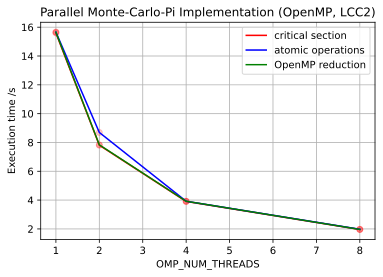

In [7]:
plt.plot(threads, critical, "ro", alpha=0.2)
plt.plot(threads, atomic, "ro", alpha=0.2)
plt.plot(threads, reduction, "ro", alpha=0.2)

plt.plot(threads, critical, "r-", label="critical section")
plt.plot(threads, atomic, "b-", label="atomic operations")
plt.plot(threads, reduction, "g-", label="OpenMP reduction")

plt.title("Parallel Monte-Carlo-Pi Implementation (OpenMP, LCC2)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")

plt.legend()
plt.grid()
plt.show()

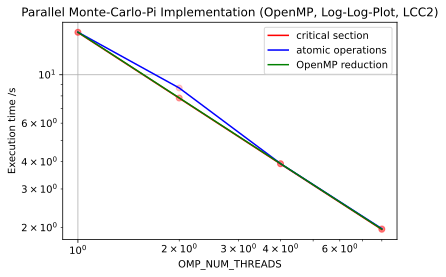

In [8]:
plt.plot(threads, critical, "ro", alpha=0.2)
plt.plot(threads, atomic, "ro", alpha=0.2)
plt.plot(threads, reduction, "ro", alpha=0.2)

plt.plot(threads, critical, "r-", label="critical section")
plt.plot(threads, atomic, "b-", label="atomic operations")
plt.plot(threads, reduction, "g-", label="OpenMP reduction")

plt.title("Parallel Monte-Carlo-Pi Implementation (OpenMP, Log-Log-Plot, LCC2)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

With the exception of atomic operations being a bit slower for 2 threads, the speedup achieved by adding more threads is almost linear.

In [9]:
data = np.array([threads, critical, atomic, reduction]).T

df = pd.DataFrame(
    data,
    index=threads,
    columns=[
        "OMP_NUM_THREADS",
        "critical /s",
        "atomic /s",
        "reduction / s",
    ]
)

HTML(df.to_html(index=False))

OMP_NUM_THREADS,critical /s,atomic /s,reduction / s
1.0,15.59850,15.65636,15.65405
2.0,7.80766,8.69438,7.83545
4.0,3.90450,3.91918,3.91884
8.0,1.95707,1.97462,1.96426


## Exercise 2: Fixing Broken Code

### Code analysis

→ `./ex2/ex2.c`

In general, the use of non-contiguous memory for all matrices (stored as arrays of row arrays) can impact performance.

Uninitialized variables affect the results of the calculation:

- matrix `c` is not initialized to zeroes, but the initial values are read during matrix multiplication (`+=` operator without initial value)
- partial results (`local_res`) are not initialized to zeroes, but they are read during the calculation of the sum over all elements of matrix `c` (`+=` operator without initial value)

Additionally, the nested `omp parallel` sections lead to duplicate computation, and wrong results when updating the partial results (since a thread with number `x` is possibly executed multiple times, the local results array elements contain cumulative partial results).

Since the final results are also not stable over multiple runs of the program, I assume that there are also race conditions when updating the `local_res` array elements, or data races between calculations of the matrix elements of `c` and the summation over its elements.

→ `./ex2/ex2_bugfree.c`

I made a minimal amount of changes that was necessary to fix all uninitialized variables and data races, so the program at least consistently returns the correct result. This already runs faster, due to the elimination of duplicated effort.

→ `./ex2/bugfix.patch`

The patch file contains an annotated diff between the original "broken" and my "minimal fix" implementations.

### Code improvements

→ `./ex2/ex2_better.c`

- use contiguous memory for matrices instead of allocating arrays of arrays
- use `calloc` for matrix `c` instead of `malloc` and manually filling memory with zeroes
- use OpenMP `reduction` operation for efficiently calculating the total sum
- optimize matrix multiplication by transposing `b` and reversing array access indices (optimizing for linear memory access)

Using optimized memory layout for the second matrix results in a much lower amount of cache read misses, especially when compiled with `-O2` optimizations (`perf stat -d PROGRAM 1500`):

- `ex2.c`: 29.87% L1 data cache misses
- `ex2_bugfree.c`: 29.65% L1 data cache misses
- `ex2_better.c`: 2.29% L1 data cache misses

### Local performance measurements

In [10]:
parser = parse.Parser("res: {result}, time: {time:2.5f} seconds")

SIZE = 1500
threads = [*range(1, THREADS+1)]

original = []
bugfree = []
better = []

# run parallel matmuladd implementations with different number of threads
for p in threads:
    ret = subprocess.run(
        ["./ex2/ex2", str(SIZE)],
        env={"OMP_NUM_THREADS": str(p)},
        stdout=subprocess.PIPE,
    )
    original.append(parser.parse(ret.stdout.decode())["time"])

    ret = subprocess.run(
        ["./ex2/ex2_bugfree", str(SIZE)],
        env={"OMP_NUM_THREADS": str(p)},
        stdout=subprocess.PIPE,
    )
    bugfree.append(parser.parse(ret.stdout.decode())["time"])

    ret = subprocess.run(
        ["./ex2/ex2_better", str(SIZE)],
        env={"OMP_NUM_THREADS": str(p)},
        stdout=subprocess.PIPE,
    )
    better.append(parser.parse(ret.stdout.decode())["time"])

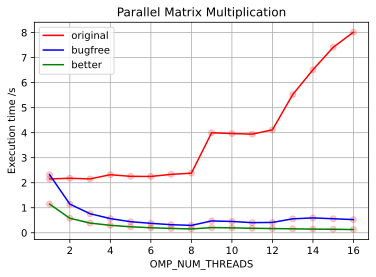

In [11]:
plt.plot(threads, original, "ro", alpha=0.2)
plt.plot(threads, bugfree, "ro", alpha=0.2)
plt.plot(threads, better, "ro", alpha=0.2)

plt.plot(threads, original, "r-", label="original")
plt.plot(threads, bugfree, "b-", label="bugfree")
plt.plot(threads, better, "g-", label="better")

plt.title("Parallel Matrix Multiplication")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")

plt.legend()
plt.grid()
plt.show()

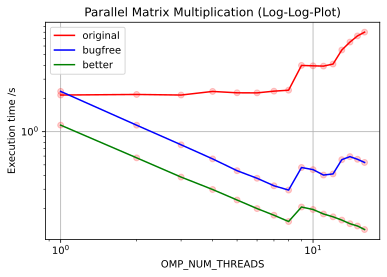

In [12]:
plt.plot(threads, original, "ro", alpha=0.2)
plt.plot(threads, bugfree, "ro", alpha=0.2)
plt.plot(threads, better, "ro", alpha=0.2)

plt.plot(threads, original, "r-", label="original")
plt.plot(threads, bugfree, "b-", label="bugfree")
plt.plot(threads, better, "g-", label="better")

plt.title("Parallel Matrix Multiplication (Log-Log-Plot)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

While the original implementation has worse performance with more threads, the version with minimal bug fixes already scales much better, and has almost linear speedup up to 8 threads, with performance worsening after that point. The better implementation has a small bump at 9 threads, but its performance continues to improve with more threads even beyond that point.

### LCC2 performance measurements

→ `./ex2/sheet_03_2.job.sh`  
→ `./ex2/sheet_03_2.dat`  

In [13]:
threads = [1, 2, 4, 8]

original = [
    20.38109,
    20.99594,
    22.07131,
    19.88496,
]

bugfree = [
    20.55769,
    10.36615,
    5.45196,
    2.81314
]

better = [
    5.05567,
    2.74597,
    1.99779,
    1.13718,
]

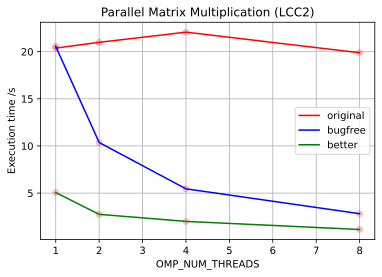

In [14]:
plt.plot(threads, original, "ro", alpha=0.2)
plt.plot(threads, bugfree, "ro", alpha=0.2)
plt.plot(threads, better, "ro", alpha=0.2)

plt.plot(threads, original, "r-", label="original")
plt.plot(threads, bugfree, "b-", label="bugfree")
plt.plot(threads, better, "g-", label="better")

plt.title("Parallel Matrix Multiplication (LCC2)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")

plt.legend()
plt.grid()
plt.show()

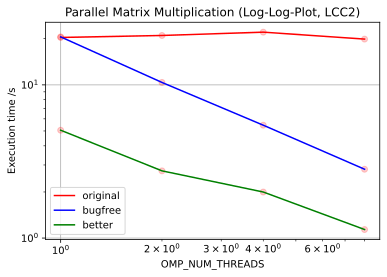

In [15]:
plt.plot(threads, original, "ro", alpha=0.2)
plt.plot(threads, bugfree, "ro", alpha=0.2)
plt.plot(threads, better, "ro", alpha=0.2)

plt.plot(threads, original, "r-", label="original")
plt.plot(threads, bugfree, "b-", label="bugfree")
plt.plot(threads, better, "g-", label="better")

plt.title("Parallel Matrix Multiplication (Log-Log-Plot, LCC2)")
plt.xlabel("OMP_NUM_THREADS")
plt.ylabel("Execution time /s")

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

Similar to local performance measurements, the original code does not scale at all (while also not yielding correct results). The bug-free code scales almost perfectly linearly with more available threads, and the optimized code is even faster, though it does not scale perfectly and has a noticable bump between 2 and 4 threads.

In [16]:
data = np.array([threads, original, bugfree, better]).T

df = pd.DataFrame(
    data,
    index=threads,
    columns=[
        "OMP_NUM_THREADS",
        "original /s",
        "bugfree /s",
        "better / s",
    ]
)

HTML(df.to_html(index=False))

OMP_NUM_THREADS,original /s,bugfree /s,better / s
1.0,20.38109,20.55769,5.05567
2.0,20.99594,10.36615,2.74597
4.0,22.07131,5.45196,1.99779
8.0,19.88496,2.81314,1.13718


## Hardware + Software

- CPU: AMD Ryzen 7 5800X (8 Cores, 16 Threads)
- OS: Fedora Workstation 33
- Compiler: `gcc (GCC) 10.2.1 20201125 (Red Hat 10.2.1-9)`
- Report: Python 3.9.4, Jupyter Notebook 6.0.3, IPython 7.18.1, ipykernel 5.2.1, numpy 1.19.4, matplotlib 3.3.4, pandas 1.0.5